In [248]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import time

In [249]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [250]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

# [[4, 2, 2]]-stabilizer

In [251]:
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

X_L_1 = tensor(X, I, X, I)
Z_L_1 = tensor(Z, Z, I, I)

X_L_2 = tensor(X, X, I, I)
Z_L_2 = tensor(Z, I, Z, I)

Text(0.5, 1.0, 'Pulses over time')

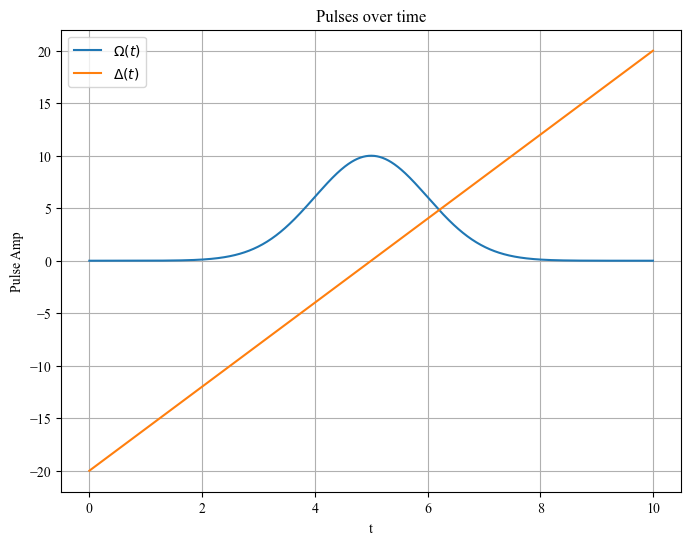

In [252]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 10
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


In [253]:
T = 10
times = np.linspace(0, T, 100)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T/2) - 1)


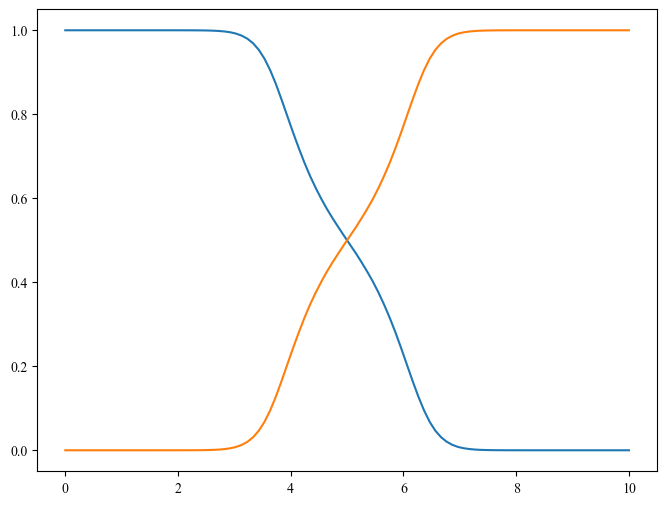

In [254]:
logical_zero = (tensor([basis(2, 0) for _ in range(4)]) + tensor([basis(2, 1) for _ in range(4)])).unit()
logical_one = X_L_1 * logical_zero

# print_quantum_state_as_superposition(logical_one)

e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

Ep = -50
H_supp = (S_X + S_Z)

def H_L(t):
    return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) + Ep * H_supp

results = sesolve(H_L, logical_zero, times, e_ops=e_ops)

plt.figure(figsize=(8, 6))
plt.plot(times, results.expect[0], label=r"$\rho_0$")
plt.plot(times, results.expect[1], label=r"$\rho_1$")
plt.show()


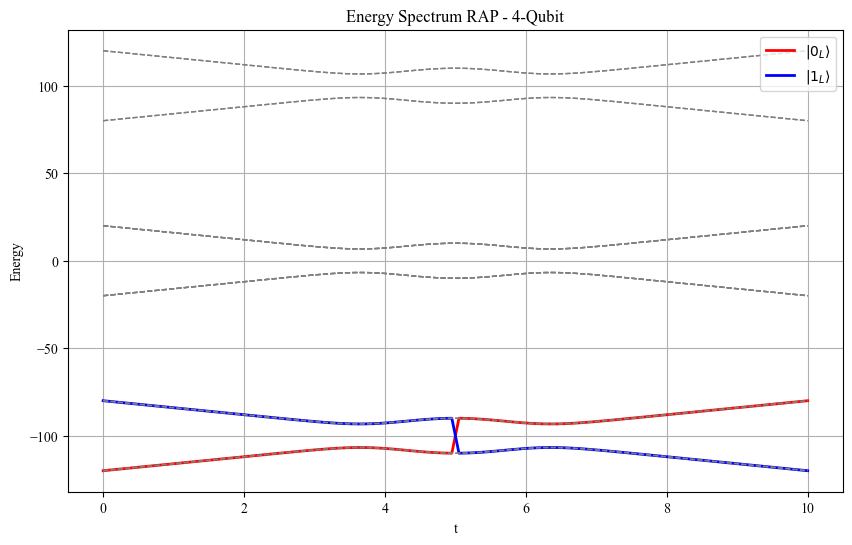

In [255]:
# Calculate the initial Hamiltonian eigenstates
H_S_0 = H_L(0)
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Logical state overlaps initialization
logical_zero_energies = []
logical_one_energies = []
other_energies = []

# Loop through time steps
for t_step in range(len(times)):
    H_S = H_L(times[t_step])
    eigenvalues, eigenstates = H_S.eigenstates()

    # Track energies for logical states
    max_overlap_zero = 0
    max_overlap_one = 0
    zero_energy = None
    one_energy = None

    for i, state_t in enumerate(eigenstates):
        overlap_zero = np.abs(logical_zero.overlap(state_t))**2
        overlap_one = np.abs(logical_one.overlap(state_t))**2
        
        if overlap_zero > max_overlap_zero:
            max_overlap_zero = overlap_zero
            zero_energy = eigenvalues[i]

        if overlap_one > max_overlap_one:
            max_overlap_one = overlap_one
            one_energy = eigenvalues[i]

    logical_zero_energies.append(zero_energy)
    logical_one_energies.append(one_energy)

    # Store all other energies
    other_energies.append([eigenvalues[i] for i in range(len(eigenvalues)) if i != zero_energy and i != one_energy])

# Plotting
plt.figure(figsize=(8, 6))

# Plot logical states
plt.plot(times, logical_zero_energies, color='red', linewidth=2, label=r"$|0_L\rangle$")
plt.plot(times, logical_one_energies, color='blue', linewidth=2, label=r"$|1_L\rangle$")

# Plot all other energies
for i in range(len(other_energies[0])):
    plt.plot(times, [other_energies[t][i] for t in range(len(times))], linestyle='dashed', color='gray', linewidth=1)

# Finalize the plot
plt.xlabel('t')
plt.ylabel('Energy')
plt.title(r'Energy Spectrum RAP - 4-Qubit')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [261]:
logical_zero = (tensor([basis(2, 0) for _ in range(4)]) + tensor([basis(2, 1) for _ in range(4)])).unit()
logical_one = X_L_1 * logical_zero

X_A = tensor(X, X, I, I)
Z_A = tensor(Z, I, Z, I)
lambda1 = -1
lambda2 = -1
nu1 = -1
nu2 = -1
x = 1
z = 1
H_supp = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A

def H_L(t):
    return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) + Ep * H_supp


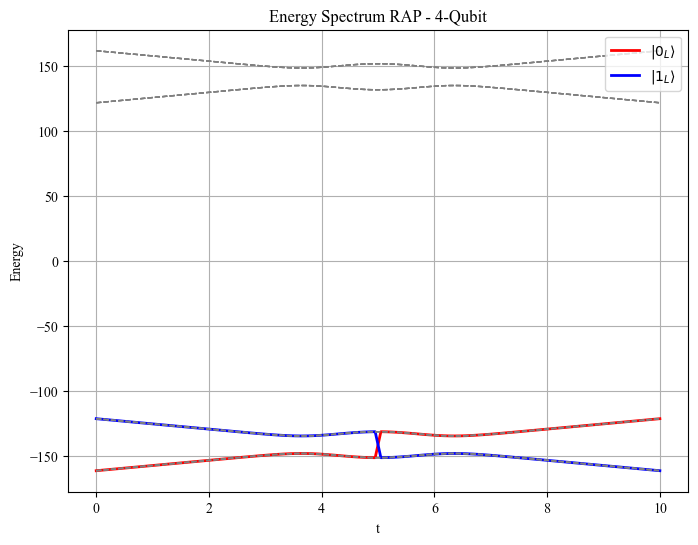

In [262]:
# Calculate the initial Hamiltonian eigenstates
H_S_0 = H_L(0)
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Logical state overlaps initialization
logical_zero_energies = []
logical_one_energies = []
other_energies = []

# Loop through time steps
for t_step in range(len(times)):
    H_S = H_L(times[t_step])
    eigenvalues, eigenstates = H_S.eigenstates()

    # Track energies for logical states
    max_overlap_zero = 0
    max_overlap_one = 0
    zero_energy = None
    one_energy = None

    for i, state_t in enumerate(eigenstates):
        overlap_zero = np.abs(logical_zero.overlap(state_t))**2
        overlap_one = np.abs(logical_one.overlap(state_t))**2
        if overlap_zero > max_overlap_zero:
            max_overlap_zero = overlap_zero
            zero_energy = eigenvalues[i]

        if overlap_one > max_overlap_one:
            max_overlap_one = overlap_one
            one_energy = eigenvalues[i]

    logical_zero_energies.append(zero_energy)
    logical_one_energies.append(one_energy)

    # Store all other energies
    other_energies.append([eigenvalues[i] for i in range(len(eigenvalues)) if i != zero_energy and i != one_energy])

# Plotting
plt.figure(figsize=(8, 6))

# Plot logical states
plt.plot(times, logical_zero_energies, color='red', linewidth=2, label=r"$|0_L\rangle$")
plt.plot(times, logical_one_energies, color='blue', linewidth=2, label=r"$|1_L\rangle$")

# Plot all other energies
for i in range(len(other_energies[0])):
    plt.plot(times, [other_energies[t][i] for t in range(len(times))], linestyle='dashed', color='gray', linewidth=1)

# Finalize the plot
plt.xlabel('t')
plt.ylabel('Energy')
plt.title(r'Energy Spectrum RAP - 4-Qubit')
plt.legend(loc='upper right')
plt.grid()
plt.show()


[-2.82842712 -2.82842712 -2.82842712 -2.82842712 -2.82842712 -2.82842712
 -2.82842712 -2.82842712  2.82842712  2.82842712  2.82842712  2.82842712
  2.82842712  2.82842712  2.82842712  2.82842712]
Energy gap of stabilizer suppression 4.0
Energy gap of gauge suppression 5.656854249492381
0.8284271247461903


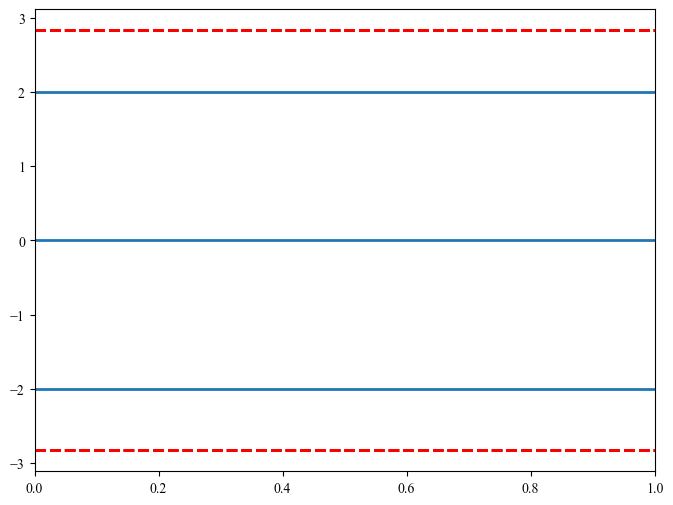

In [237]:
# Stabilizers
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

# Gauge Operators
X_A = tensor(X, X, I, I)
Z_A = tensor(Z, I, Z, I)
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = 1
z = 1

H_supp_stab = S_X + S_Z
H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A

energies_stab = H_supp_stab.eigenenergies()
energies_gauge = H_supp_gauge.eigenenergies()

plt.figure(figsize=(8, 6))
s_energies = []
for energy in energies_stab:
    if energy not in s_energies:
        plt.axhline(y = energy, linestyle = '-', linewidth = 2)
    s_energies.append(energy)
for energy in energies_gauge: 
    plt.axhline(y = energy, linestyle = '--', linewidth = 2, color = 'red')

print(energies_gauge)
# Calculate energy gaps
gap_stab = np.max(energies_stab) - np.min(energies_stab)
gap_gauge = np.max(energies_gauge) - np.min(energies_gauge)
print("Energy gap of stabilizer suppression", gap_stab)
print("Energy gap of gauge suppression", gap_gauge)
print(2*(np.sqrt(2) - 1))